# Modelos estadísticos para predecir si un texto es humorístico

In [7]:
import pandas as pd
data = pd.read_csv("/content/dataset (b).csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             200000 non-null  object
 1   humor            200000 non-null  bool  
 2   normalized_text  199999 non-null  object
 3   length           200000 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 4.8+ MB


## Preprocesamiento y vectorización

Antes de entrenar un modelo de clasificación con textos, es necesario transformarlos en una representación numérica. Este preprocesamiento incluye la eliminación de palabras vacías (stopwords) y de números, ya que suelen aportar poco valor para la tarea de clasificación. Luego se aplica una técnica llamada TF-IDF, que asigna a cada palabra un peso basado en su frecuencia dentro de cada texto y en el corpus completo. El resultado es una matriz dispersa en la que cada fila representa un texto y cada columna una palabra seleccionada del vocabulario. Esta matriz será utilizada como entrada para el modelo de aprendizaje automático.

**Nota.** TF-IDF (Term Frequency–Inverse Document Frequency) es una técnica utilizada para convertir texto en números de forma que refleja la importancia relativa de cada palabra . La "frecuencia de término" (TF) mide cuantas veces aparece una palabra en un texto, mientras que la "frecuencia inversa de documento" (IDF) penaliza palabras muy comunes en todo el corpus. Así, TF-IDF asigna un peso mayor a las palabras que son frecuentes en un texto pero raras en general , ayudando a distinguir el contenido significativo del ruido lingüístico. Esta técnica es ampliamente utilizada en tareas de clasificación de texto, búsqueda de información y análisis de contenido.

In [43]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocesador para eliminar números.
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Crea un vectorizador TF-IDF que:
# - usa solo las 50 palabas más frecuentes (max_features=50).
# - considera solo unigramas (ngram_range=(1,1)).
# - elimina stopwords en inglés (stop_words='english').
# - elimina números antes de tokenizar (preprocessor=remove_numbers).
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), preprocessor=remove_numbers)

# Elimina filas con valores faltantes en la columna 'normalized_text' para evitar errores.
data_clean = data.dropna(subset=['normalized_text'])

# Aplica el vectorizador a los textos normalizados (ya sin NaNs) y obtiene la matriz IF-IDF.
X = vectorizer.fit_transform(data_clean['normalized_text'])
# X es una matriz dispersa (sparse matrix) de tamaño (n_samples=50) que contiene los valores TF-IDF de las 50 palabras más frecuentes.
# X tiene la forma Coords ('número fila-texto', 'número de palabra-índice del vocabulario') Values 'peso TF-IDF'.

# Extrae la variable objetivo (1 = humorístico, 0 = no humorístico) del DataFrame.
y = data_clean['humor']

**Nota:** Se optó por no eliminar *stopwords*, ya que el modelo probablemente las ignore por tener TF-IDF muy bajos. Además, se hizo la prueba eliminamdo los stopwords y la precisión disminuyó considerablemente.

Dividimos datos en entrenamiento y prueba.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión logística

La regresión logística es un modelo estadístico que en este caso predice la probabilidad de que un texto sea humorístico o no, a partir de los valores TF-IDF de las palabras. Cada palabra del vocabulario se convierte en una variable que contribuye a la decisión del modelo con un peso (coeficiente) aprendido durante el entrenamiento. El modelo combina todos estos valores y aplica una función logística para producir una probabilidad entre 0 y 1. Si esta probabilidad supera cierto umbral (usualmente 0.5), el texto se clasifica como humorístico; si no, como no humorístico.


Accuracy: 0.94075

Classification report:
               precision    recall  f1-score   support

       False       0.94      0.95      0.94     19853
        True       0.95      0.94      0.94     20147

    accuracy                           0.94     40000
   macro avg       0.94      0.94      0.94     40000
weighted avg       0.94      0.94      0.94     40000



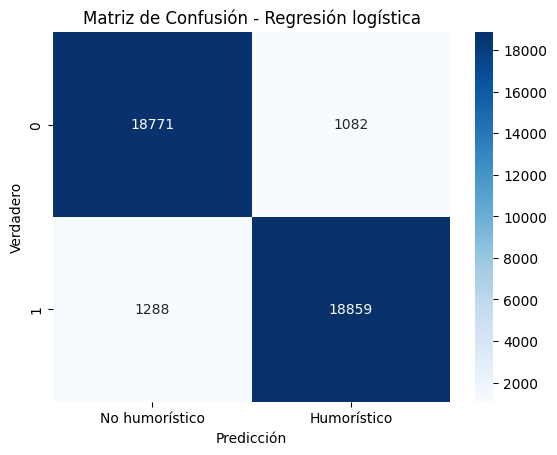

In [46]:
# Entrenamiento del modelo.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba.
y_pred = model.predict(X_test)

# Evaluación del modelo.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Matriz de confusión.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No humorístico', 'Humorístico'])
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - Regresión logística")
plt.show()

La precisión global del modelo es de 0.94, lo cual indica que está clasificando correctamente el 94 % de los textos. En particular, está identificando correctamente el 94 % de los textos humorísticos como humorísticos, y el 95 % de los textos no humorísticos como no humorísticos. Esto último se confirma con las cifras de la matriz de confusión.

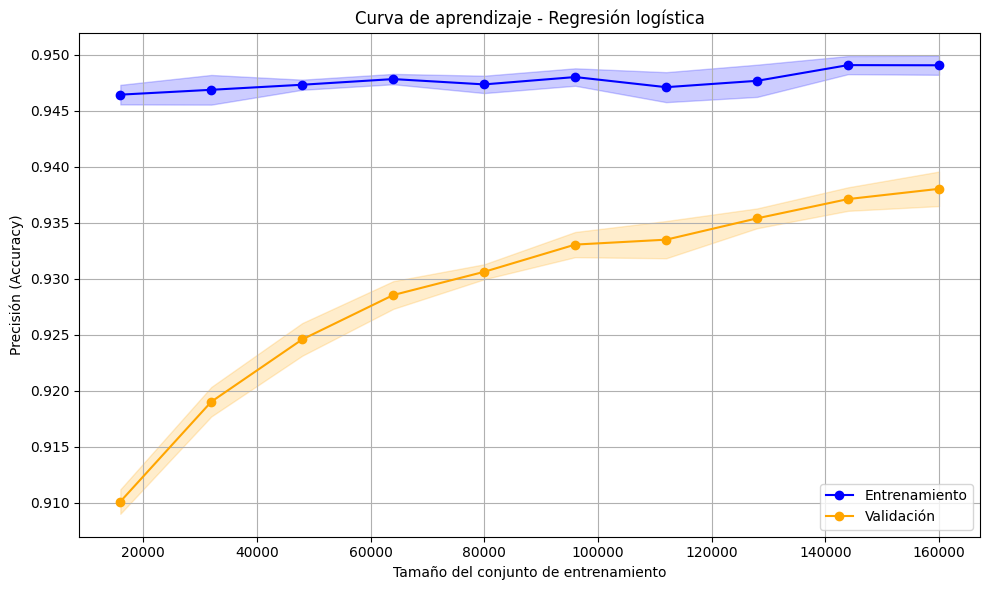

In [47]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

model = LogisticRegression(max_iter=1000)

# Curva de aprendizaje.
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Promedios y desviaciones estándar.
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Entrenamiento')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validación')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='orange')

plt.title('Curva de aprendizaje - Regresión logística')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión (Accuracy)')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


La curva de aprendizaje muestra un comportamiento saludable del modelo de regresión logística. La precisión sobre el conjunto de entrenamiento se mantiene alta y estable (~0.92), mientras que la precisión en validación incrementa de forma constante conforme se utilizan más datos, alcanzando aproximadamente 0.90.

Esto indica que el modelo está aprendiendo correctamente sin sobreajustar: la brecha entre las curvas es pequeña y se reduce ligeramente a medida que aumenta el tamaño del conjunto de entrenamiento. Además, las curvas tienden a estabilizarse, lo cual sugiere que el modelo está cerca de su capacidad óptima y que añadir más datos podría mejorar marginalmente su rendimiento, aunque ya se ha alcanzado una generalización bastante buena.

## Nayve Bayes

Naive Bayes es un modelo de clasificación probabilística que en este caso predice la clase de un texto (si es humorístico o no) basándose en las palabras que contiene. Utiliza el teorema de Bayes con el supuesto de que todas las palabras son independientes entre sí, lo cual simplifica mucho los cálculos. A pesar de esta suposición ingenua, funciona muy bien en tareas de procesamiento de lenguaje natural, ya que aprovecha eficientemente las palabras más representativas de cada clase.


**Nota 1:** Naive Bayes ha demostrado ser altamente efectivo y sorprendentemente competitivo en tareas de clasificación de texto como filtrado de spam, detección de sentimientos o, como en este caso, detección de humor.

**Nota 2:** Se utiliza la variante MultinomialNB porque es especialmente adecuada para datos de texto representados como conteos o pesos TF-IDF, donde las características (palabras) aparecen múltiples veces y su frecuencia aporta información relevante para la clasificación.

Accuracy: 0.930925

Classification report:
               precision    recall  f1-score   support

       False       0.93      0.93      0.93     19853
        True       0.93      0.94      0.93     20147

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000



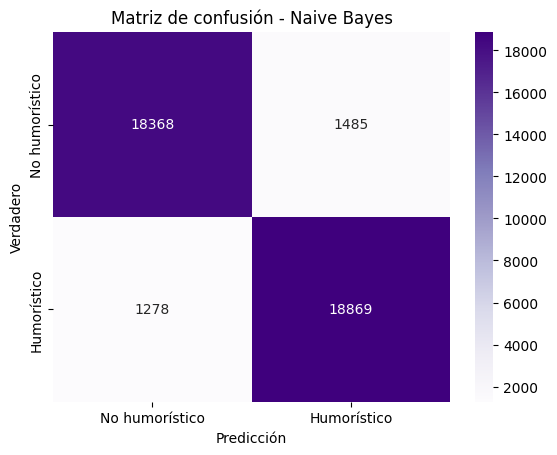

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamiento.
model = MultinomialNB()
model.fit(X_train, y_train)

# Predicción.
y_pred = model.predict(X_test)

# Evaluación del modelo.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Matriz de confusión.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
             xticklabels=['No humorístico', 'Humorístico'],
             yticklabels=['No humorístico', 'Humorístico'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión - Naive Bayes')
plt.show()

La precisión global de este modelo es 0.93. En este caso, el 94 % de los textos humorísticos se clasifican correctamente como humorísticos, y el 93 % de los no humorísticos se clasifican correctamente como no humorísticos. Esto último se confirma con las cifras de la matriz de confusión.

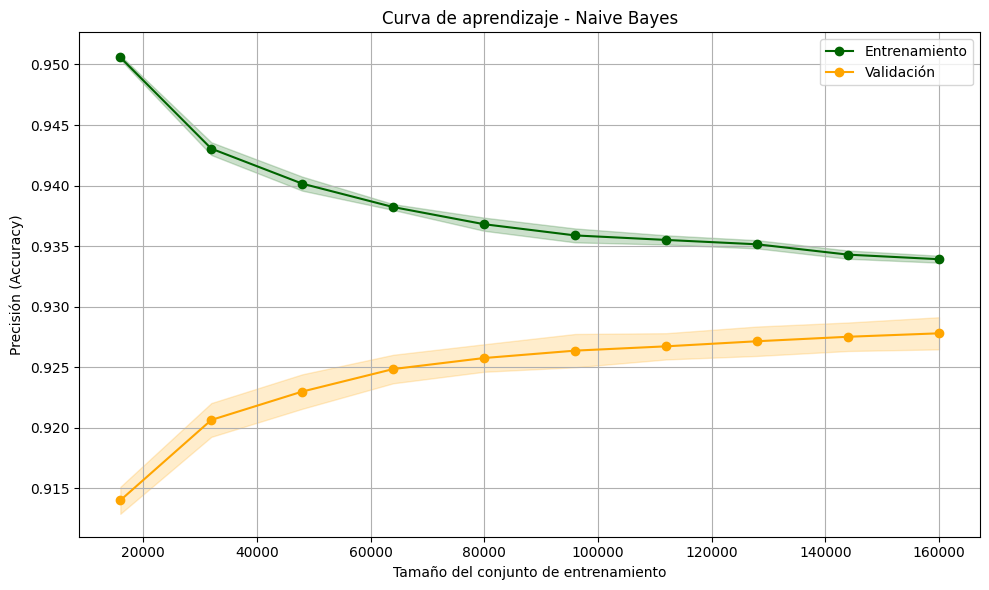

In [49]:
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt

# Modelo Naive Bayes.
model_nb = MultinomialNB()

# Calcular curva de aprendizaje.
train_sizes, train_scores, test_scores = learning_curve(
    model_nb, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular promedios y desviaciones estándar.
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento', color='darkgreen')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='darkgreen')

plt.plot(train_sizes, test_mean, 'o-', label='Validación', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')

plt.title("Curva de aprendizaje - Naive Bayes")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión (Accuracy)")
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


La curva de aprendizaje usando Naive Bayes muestra que este modelo tiene también un buen comportamiento. Las precisiones para los datos de entrenamiento y precisión son ligeramente inferiores al caso de regresión logística, pero son prácticamente iguales. Además, la brecha entre las curvas es más pequeña a medida que aumenta el tamaño del conjunto de datos de entrenamiento, más que en el caso de regresión logística. Las curvas tienden a estabilizarse, lo cual sugiere que el modelo está cerca de su capacidad óptima.

## Random Forest

Random Forest es un modelo de clasificación basado en un conjunto de árboles de decisión. Cada árbol se entrena con una parte diferente de los datos y vota por una clase; la decisión final se toma por mayoría. Este enfoque lo hace robusto al sobreajuste y efectivo para tareas complejas. En el contexto del procesamiento de lenguaje natural, Random Forest puede aprovechar las representaciones numéricas del texto (como TF-IDF) para identificar patrones en las palabras que distinguen una clase de otra. Aunque no es el más eficiente para grandes volúmenes de texto, puede ofrecer buenos resultados y es útil para comparar con modelos más simples como regresión logística o Naive Bayes.


Accuracy: 0.9193

Classification report:
               precision    recall  f1-score   support

       False       0.92      0.92      0.92     19853
        True       0.92      0.92      0.92     20147

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



<function matplotlib.pyplot.show(close=None, block=None)>

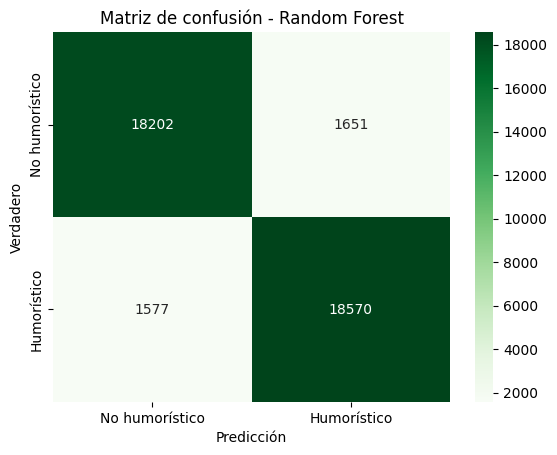

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Crear y entrenar el modelo.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predicciones.
y_pred = model.predict(X_test)

# Evaluación.
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Matriz de confusión.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No humorístico', 'Humorístico'],
            yticklabels=['No humorístico', 'Humorístico'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión - Random Forest')
plt.show

La precisión global de este modelo es de aproximadamente 0.92. En este caso, el 92 % de los textos humorísticos se clasifican correctamente como humorísticos, y el 92 % de los no humorísticos se clasifican correctamente como no humorísticos. Esto último se confirma con las cifras de la matriz de confusión.

## Conclusiones

* El modelo de regresión logística fue el que tuvo mayor precisión, seguido por Naive Bayes.

* La precisión del modelo de regresión logística (0.94) es muy buena para clasificar a un texto como humorístico o no humorístico.

* La curva de aprendizaje muestra que la elección de fracciones del número de datos para entrenamiento y prueba fue óptima (80 y 20, respectivamente), puesto que con esta fracción la precisión parece estabilizarse, y añadir más datos al conjunto de entrenamiento ya no proporciona mejoras significativas.

* Eliminar stopwords disminuye considerablemente la precisión (0.03 aproximadamente).

* Considerar bigramas (pares de palabras consecutivas, n-gramas de 2 palabras) proporcionó mayor precisión que considerar unigramas (palabras individuales, n-gramas de 1 palabra).